In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.preprocessing import OneHotEncoder
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt

DIR_val_train = "Encode_data/ang_enc_data_set_trainning_values.csv"
DIR_cls_train = "Encode_data/ang_enc_data_set_trainning_classes.csv"

DIR_val_test = "Encode_data/ang_enc_data_set_test_values.csv"
DIR_cls_test = "Encode_data/ang_enc_data_set_test_classes.csv"

# Circuito

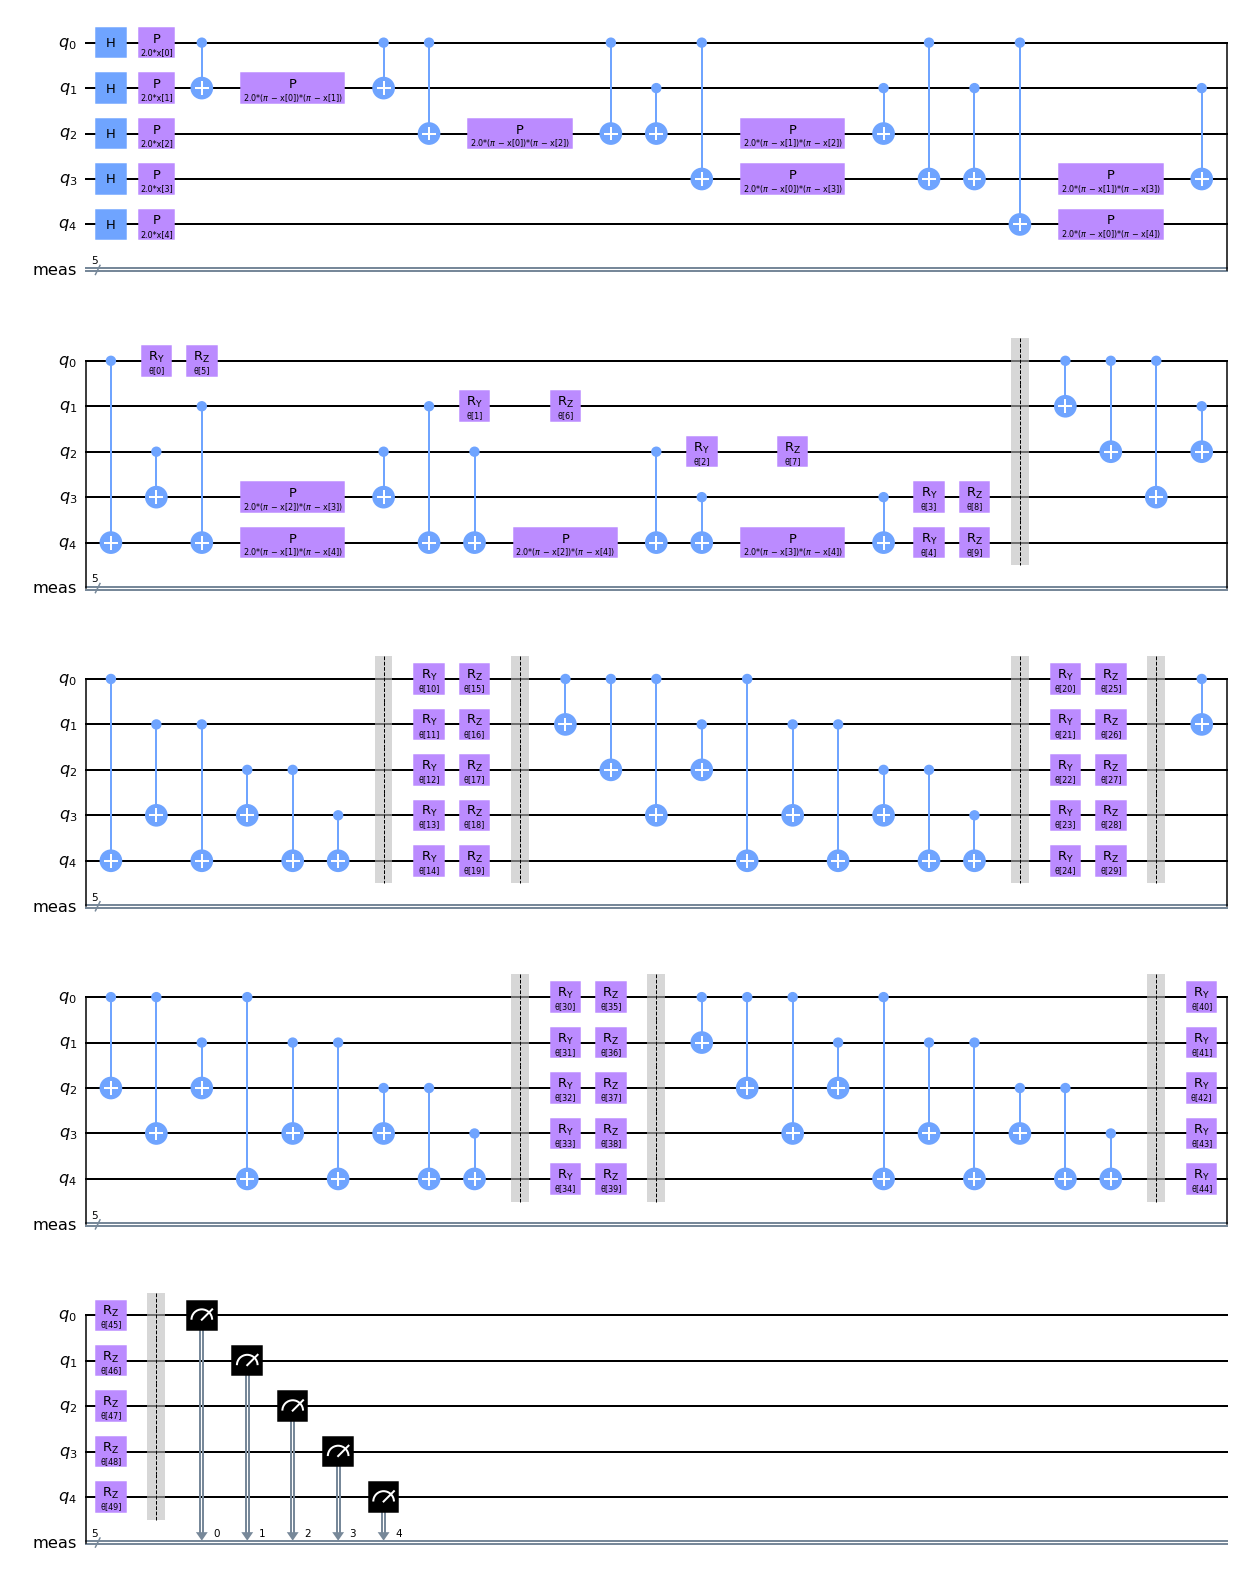

In [2]:
n_qubits = 5

encoding = ZZFeatureMap(feature_dimension=n_qubits, reps=1)

ansatz = EfficientSU2(n_qubits, entanglement='full', reps=4, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")
qc = encoding.compose(ansatz)
qc.measure_all()
qc.decompose().draw(output="mpl")

In [3]:
train_data = np.genfromtxt(DIR_val_train, delimiter=";")
train_labels = np.genfromtxt(DIR_cls_train, delimiter=";")

test_data = np.genfromtxt(DIR_val_test, delimiter=";")
test_labels = np.genfromtxt(DIR_cls_test, delimiter=";")

In [4]:
def circuit_parameters(encoding, ansatz, x, thetas, self_encoding=False):
    parameters = {}
    if self_encoding:
        for i, p in enumerate(list(encoding.parameters)):
            parameters[p] = x[i]
    else:
        for i, p in enumerate(list(encoding.ordered_parameters)):
            parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

In [5]:

def train(qc, encoding, ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=200 , learning_rate=lr, perturbation=0.01, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=200, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(qc,encoding, ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)
        
        # Run the optimization
        opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

        return opt_var, opt_value , parameters, costs, evaluations 

## Mean Square error

### Multi Qubit exp val

$$Cost() = \frac{1}{N}\sum (y-\hat{y})^2$$


In [6]:
train_labels_oh = train_labels
test_labels_oh = test_labels

In [7]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [classification(results.get_counts(c)) for c in circuits]
    #print(predictions)
    cost = np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost {cost}")
    return cost

In [8]:
#%%script echo skipping
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    
    """
    Retorna as probabilidades de cada estado
    """
    
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


def classification(counts, shots=1024, label=True):
    
    def count_ones(string):
        r = 0
        for char in string:
            if char == "1":
                r+=1
        return r
    
    def label_assign(exp_val):
        if exp_val >= 0:
            r = 1
        else:
            r = -1
        return r

    probs = basis_states_probs(counts, n_qubits=n_qubits)
    states = ["".join(seq) for seq in itr.product("01", repeat=n_qubits)]
    
    exp_val = 0
    for state, prob in zip(states, probs):
        #print(prob, state)
        exp_val += ((-1)**(count_ones(state)%2))*prob
    
    #print(f"Valor expectávlel {exp_val}, Label {label_assign(exp_val)} ")
    if label:
        return label_assign(exp_val)
    else:
        return exp_val
    
def loss_function(y,y_hat):
    #print(f"Loss {y}-{y_hat}**2")
    #print(f"Loss {(y-y_hat)**2}")
    return (y-y_hat) * (y-y_hat)

In [9]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

Cost 2.2
Cost 2.466666666666667
Cost 2.066666666666667
Cost 2.1333333333333333
Cost 2.066666666666667
Cost 1.6666666666666667
Cost 2.1333333333333333
Cost 2.066666666666667
Cost 1.6666666666666667
Cost 2.2
Cost 2.533333333333333
Cost 1.6666666666666667
Cost 2.066666666666667
Cost 2.2
Cost 2.4
Cost 1.8
Cost 2.1333333333333333
Cost 2.466666666666667
Cost 2.1333333333333333
Cost 1.8
Cost 2.3333333333333335
Cost 1.6666666666666667
Cost 2.466666666666667
Cost 1.8666666666666667
Cost 2.066666666666667
Cost 2.6
Cost 2.6666666666666665
Cost 2.2666666666666666
Cost 1.8
Cost 2.4
Cost 2.0
Cost 1.9333333333333333
Cost 1.6666666666666667
Cost 2.1333333333333333
Cost 1.4666666666666666
Cost 2.6
Cost 2.533333333333333
Cost 2.1333333333333333
Cost 2.2
Cost 2.2666666666666666
Cost 2.2
Cost 2.3333333333333335
Cost 2.4
Cost 2.1333333333333333
Cost 2.3333333333333335
Cost 2.2666666666666666
Cost 2.6666666666666665
Cost 1.4666666666666666
Cost 2.066666666666667
Cost 2.533333333333333
Cost 2.2
Cost 2.4
Cost

Cost 0.7333333333333333
Cost 0.6
Cost 1.0666666666666667
Cost 0.6666666666666666
Cost 0.8666666666666667
Cost 0.7333333333333333
Cost 0.6666666666666666
Cost 0.9333333333333333
Cost 0.9333333333333333
Cost 0.6
Cost 1.2
Cost 0.8666666666666667
Cost 0.8
Cost 1.1333333333333333
Cost 1.1333333333333333
Cost 0.7333333333333333
Cost 1.2666666666666666
Cost 1.0666666666666667
Cost 0.9333333333333333
Cost 1.0666666666666667
Cost 1.2666666666666666
Cost 0.8
Cost 1.2666666666666666
Cost 1.2666666666666666
Cost 1.0
Cost 1.2
Cost 1.2
Cost 0.9333333333333333
Cost 1.0666666666666667
Cost 0.7333333333333333
Cost 0.7333333333333333
Cost 1.3333333333333333
Cost 1.0
Cost 0.8666666666666667
Cost 1.0
Cost 0.8666666666666667
Cost 0.8
Cost 1.0
Cost 0.8666666666666667
Cost 0.9333333333333333
Cost 0.7333333333333333
Cost 1.0666666666666667
Cost 0.6
Cost 0.9333333333333333
Cost 1.2
Cost 0.8666666666666667
Cost 0.7333333333333333
Cost 1.0666666666666667
Cost 0.8
Cost 0.8
Cost 0.8666666666666667
Cost 0.733333333

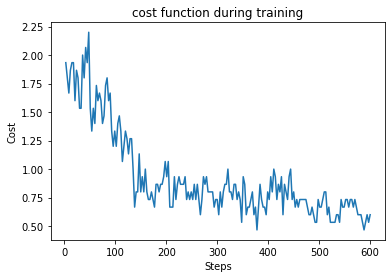

In [10]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [11]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]
    #print(circuits)

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    prediction = [classification(results.get_counts(c)) for c in circuits]
    print(f"Predictions: {prediction}")
    print(f"Labels: {labels}")
    #prediction = [0 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [12]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

Predictions: [-1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1]
Labels: [ 1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1.]
Test set accuracy - 0.5555555555555556


## Cross Entropy Loss

### Parity method

In [13]:
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [14]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    
    return probs
def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2

def loss_function(y,y_hat):
    #print(y_hat)
    return np.sum(y*np.log(y_hat))

In [15]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]

    cost = -np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost: {cost}")
    
    return cost

In [16]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

Cost: 0.6775834711095644
Cost: 0.677433324642651
Cost: 0.6891944726257001
Cost: 0.6643283029962544
Cost: 0.6536607245893068
Cost: 0.704298007613289
Cost: 0.6378050218564516
Cost: 0.7011465734242833
Cost: 0.6744214503421756
Cost: 0.6926908476663173
Cost: 0.6787726494571855
Cost: 0.6873050319892519
Cost: 0.6346323771244672
Cost: 0.7119734900287571
Cost: 0.6960108204847704
Cost: 0.6899194251563351
Cost: 0.6642223738688225
Cost: 0.7125548937300746
Cost: 0.7005397438168433
Cost: 0.6862972294338956
Cost: 0.6425917884409977
Cost: 0.697990071816114
Cost: 0.7010366886409177
Cost: 0.6429744081911758
Cost: 0.7053501884406284
Cost: 0.6415104707364908
Cost: 0.6418661740947196
Cost: 0.7270581962018438
Cost: 0.6729594797045573
Cost: 0.6759515177717657
Cost: 0.6966233099843978
Cost: 0.6573851234595972
Cost: 0.6887726625175151
Cost: 0.6310047755401951
Cost: 0.6642617490220736
Cost: 0.7075902724927642
Cost: 0.6791956943647638
Cost: 0.7491758035324111
Cost: 0.6713635283471557
Cost: 0.6713896289124234
Cos

Cost: 0.5759012325100473
Cost: 0.5753358056107812
Cost: 0.5434537047745565
Cost: 0.5661651659420351
Cost: 0.577161504810929
Cost: 0.5454023007333616
Cost: 0.589010746135637
Cost: 0.5654637896943479
Cost: 0.5474757234930039
Cost: 0.5820124860822322
Cost: 0.5801314668598805
Cost: 0.5490664390645399
Cost: 0.5733278195690444
Cost: 0.5732358463535931
Cost: 0.5499887243401146
Cost: 0.5536158906292278
Cost: 0.5999712345342844
Cost: 0.5388627380782818
Cost: 0.5920677656569306
Cost: 0.5426231544694282
Cost: 0.5394102982804425
Cost: 0.5550641234584288
Cost: 0.5730541505265011
Cost: 0.5355586345222576
Cost: 0.5751639419074974
Cost: 0.5652643780869171
Cost: 0.5375394510419238
Cost: 0.564955573792822
Cost: 0.5648277228430393
Cost: 0.5330724591939366
Cost: 0.5754389786321842
Cost: 0.5619683396789384
Cost: 0.5345431053362025
Cost: 0.5839695545885148
Cost: 0.5636820511140388
Cost: 0.5333989641253644
Cost: 0.5417038213426711
Cost: 0.5938242569045679
Cost: 0.5394247524332969
Cost: 0.5529791019778457
Cos

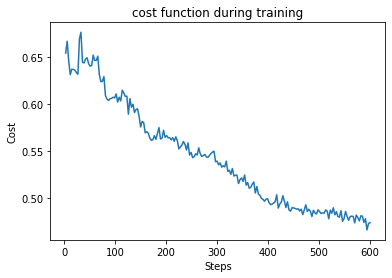

In [17]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [18]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]
    prediction = [-1 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(prediction)
    print(labels)
    for i, p in enumerate(prediction):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [19]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

[1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1]
[ 1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1.]
Test set accuracy - 0.7222222222222222


In [20]:
print(len(train_data))

60


In [21]:
print(train_data)

[[ 3.14159265e+00  2.29741330e-03  1.14011586e-01  2.10119278e-02
  -1.29933915e-02]
 [-6.37130079e+01  2.25838996e+00 -6.43123320e-01  3.14159265e+00
  -1.73081318e+00]
 [ 3.14159265e+00 -3.51631155e+00 -7.04172115e-01 -2.60617744e-02
  -5.49121708e-02]
 [-1.35325859e+01 -9.00452007e+00 -1.23053626e+00  3.14159265e+00
   4.76091155e-01]
 [ 3.14159265e+00 -8.69872440e-02 -1.74877414e-01  2.46784289e-01
   7.71369228e-02]
 [ 3.14159265e+00  5.54890681e-01  1.89872985e-02  5.81671693e-03
  -2.01017996e-02]
 [ 3.14159265e+00  1.18327957e+00  6.45625325e-02 -4.69699704e-02
  -3.74045424e-03]
 [ 3.14159265e+00 -2.84448882e+00 -2.05031836e+00  5.77032964e-01
   1.74881768e-01]
 [-6.23795681e+01 -2.22973407e+00 -8.56281420e-01 -5.33784234e+00
   3.14159265e+00]
 [ 3.14159265e+00 -3.58217958e-02  1.48072375e-01 -1.74689932e-02
   2.81472899e-02]
 [-9.86095896e+02  3.14159265e+00 -1.91920853e+02 -1.46484037e+02
  -1.66876853e+01]
 [ 3.14159265e+00 -1.64597381e+00  1.64046809e+00  3.28138126e-01